In [11]:
import OpenDartReader
import pandas as pd

# OpenDartReader 초기화 (여기에 당신의 Open DART API 키를 입력하세요)
api_key = '2acfb3748d8e22914e66fa6fbc6cbac4d3e8cc7c'
dart = OpenDartReader(api_key)

# 삼성전자 종목 코드
corp_code = '00126380'  # 삼성전자의 DART 상 종목코드 (DART 사이트에서 확인 가능)

# 분기별 재무제표 데이터를 가져오기 위한 보고서 코드
report_codes = {
    'Q1': '11013',
    'Q2': '11012',
    'Q3': '11014',
    'Q4': '11011'
}

# 2016년부터 2023년까지의 분기별 재무제표 데이터 가져오기
quarterly_revenue_data = []

for year in range(2016, 2024):
    yearly_total = 0
    for quarter, report_code in report_codes.items():
        fs = dart.finstate(corp_code, year, reprt_code=report_code)
        
        if fs is not None and not fs.empty:
            # 'account_nm' 열이 있는지 확인
            if 'account_nm' in fs.columns:
                # 매출액 데이터 추출
                revenue = fs[fs['account_nm'] == '매출액']['thstrm_amount'].values
                if len(revenue) > 0:
                    revenue_value = int(revenue[0].replace(',', ''))
                    if quarter != 'Q4':
                        quarterly_revenue_data.append([f'{year}-Q{int(quarter[-2])}', revenue_value])
                        yearly_total += revenue_value
                    else:
                        # 4분기 매출액은 연간 매출액에서 1, 2, 3분기 매출액을 뺀 값으로 계산
                        annual_revenue = revenue_value
                        q4_revenue = annual_revenue - yearly_total
                        quarterly_revenue_data.append([f'{year}-Q{int(quarter[-2])}', q4_revenue])
            else:
                print(f"'account_nm' column not found for year {year}, quarter {quarter}")
        else:
            print(f"No data or empty dataframe for year {year}, quarter {quarter}")

'''
# 데이터프레임 생성
df = pd.DataFrame(quarterly_revenue_data, columns=['Year', 'Quarter', 'Revenue'])
'''
# 데이터프레임 생성
df = pd.DataFrame(quarterly_revenue_data, columns=['ds', 'y'])
df

ValueError: invalid literal for int() with base 10: 'Q'

In [ ]:
import matplotlib.pyplot as plt
from prophet import Prophet

In [ ]:
# 날짜 형식 변환
df['ds'] = pd.to_datetime(df['ds'].str.replace(r'Q(\d)', r'0\1', regex=True))

# Prophet 모델 학습
model = Prophet()
model.fit(df)

# 미래 5년간의 매출 예측
future = model.make_future_dataframe(periods=20, freq='Q')
forecast = model.predict(future)

# 결과 출력
import ace_tools as tools; tools.display_dataframe_to_user(name="Samsung Electronics Quarterly Revenue Predictions (using Prophet)", dataframe=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

# 시각화
fig = model.plot(forecast)
plt.title('Samsung Electronics Quarterly Revenue Prediction (2024-2028)')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.show()

ValueError: 2 columns passed, passed data had 3 columns

In [23]:
!brew install libomp

zsh:1: command not found: brew


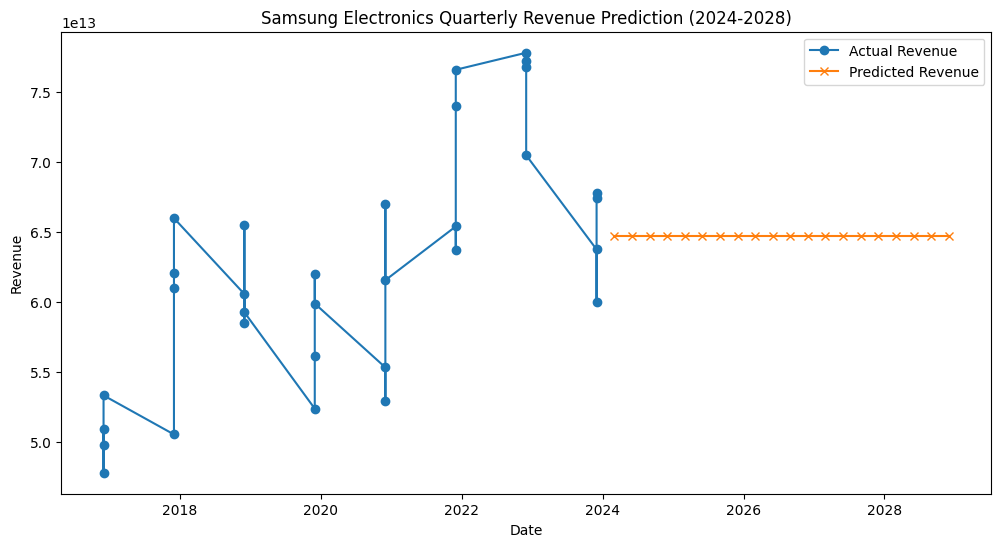

           ds          yhat
0  2024-03-01  6.473387e+13
1  2024-06-01  6.473387e+13
2  2024-09-01  6.473387e+13
3  2024-12-01  6.473387e+13
4  2025-03-01  6.473387e+13
5  2025-06-01  6.473387e+13
6  2025-09-01  6.473387e+13
7  2025-12-01  6.473387e+13
8  2026-03-01  6.473387e+13
9  2026-06-01  6.473387e+13
10 2026-09-01  6.473387e+13
11 2026-12-01  6.473387e+13
12 2027-03-01  6.473387e+13
13 2027-06-01  6.473387e+13
14 2027-09-01  6.473387e+13
15 2027-12-01  6.473387e+13
16 2028-03-01  6.473387e+13
17 2028-06-01  6.473387e+13
18 2028-09-01  6.473387e+13
19 2028-12-01  6.473387e+13


In [28]:
import OpenDartReader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# OpenDartReader 초기화 (여기에 당신의 Open DART API 키를 입력하세요)
api_key = '2acfb3748d8e22914e66fa6fbc6cbac4d3e8cc7c'
dart = OpenDartReader(api_key)

# 삼성전자 종목 코드
corp_code = '00126380'  # 삼성전자의 DART 상 종목코드 (DART 사이트에서 확인 가능)

# 분기별 재무제표 데이터를 가져오기 위한 보고서 코드
report_codes = {
    'Q1': '11013',
    'Q2': '11012',
    'Q3': '11014',
    'Q4': '11011'
}

# 2016년부터 2023년까지의 분기별 재무제표 데이터 가져오기
quarterly_revenue_data = []

for year in range(2016, 2024):
    yearly_total = 0
    for quarter, report_code in report_codes.items():
        fs = dart.finstate(corp_code, year, reprt_code=report_code)
        
        if fs is not None and not fs.empty:
            # 'account_nm' 열이 있는지 확인
            if 'account_nm' in fs.columns:
                # 매출액 데이터 추출
                revenue = fs[fs['account_nm'] == '매출액']['thstrm_amount'].values
                if len(revenue) > 0:
                    revenue_value = int(revenue[0].replace(',', ''))
                    if quarter != 'Q4':
                        date_str = f"{year}-{'03' if quarter == '11013' else '06' if quarter == '11012' else '09' if quarter == '11014' else '12'}-01"
                        quarterly_revenue_data.append([date_str, revenue_value])
                        yearly_total += revenue_value
                    else:
                        # 4분기 매출액은 연간 매출액에서 1, 2, 3분기 매출액을 뺀 값으로 계산
                        annual_revenue = revenue_value
                        q4_revenue = annual_revenue - yearly_total
                        date_str = f"{year}-12-01"
                        quarterly_revenue_data.append([date_str, q4_revenue])
            else:
                print(f"'account_nm' column not found for year {year}, quarter {quarter}")
        else:
            print(f"No data or empty dataframe for year {year}, quarter {quarter}")

# 데이터프레임 생성
df = pd.DataFrame(quarterly_revenue_data, columns=['ds', 'y'])

# 'ds'를 datetime 형식으로 변환
df['ds'] = pd.to_datetime(df['ds'])

# 특징 공학: 분기, 연도 등을 분리
df['quarter'] = df['ds'].dt.quarter
df['year'] = df['ds'].dt.year

# 데이터 준비
X = df[['year', 'quarter']]
y = df['y']

# XGBoost 모델 학습
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(X, y)

# 2024년부터 2028년까지의 분기 데이터 생성
future_years = np.arange(2024, 2029)
future_quarters = [1, 2, 3, 4]
future_data = [(year, quarter) for year in future_years for quarter in future_quarters]
future_df = pd.DataFrame(future_data, columns=['year', 'quarter'])

# 미래 데이터 예측
future_predictions = model.predict(future_df)

# 예측 결과 데이터프레임 생성
future_df['yhat'] = future_predictions
future_df['ds'] = future_df.apply(lambda row: f"{int(row['year'])}-{'03' if row['quarter'] == 1 else '06' if row['quarter'] == 2 else '09' if row['quarter'] == 3 else '12'}-01", axis=1)
future_df['ds'] = pd.to_datetime(future_df['ds'])

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'], label='Actual Revenue', marker='o')
plt.plot(future_df['ds'], future_df['yhat'], label='Predicted Revenue', marker='x')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Samsung Electronics Quarterly Revenue Prediction (2024-2028)')
plt.legend()
plt.show()

# 예측된 매출 출력
print(future_df[['ds', 'yhat']])

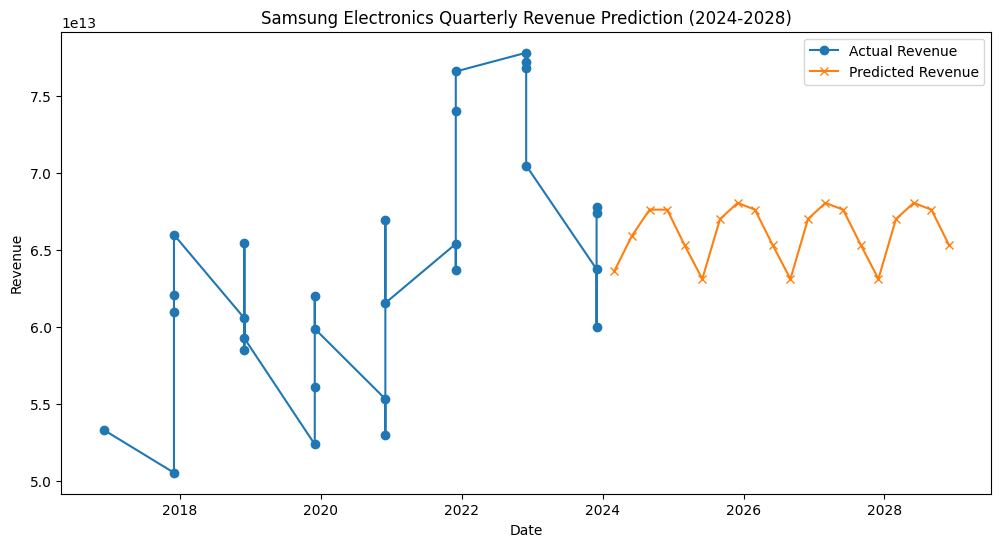

           ds          yhat
0  2024-03-01  6.359608e+13
1  2024-06-01  6.590951e+13
2  2024-09-01  6.761014e+13
3  2024-12-01  6.760419e+13
4  2025-03-01  6.530659e+13
5  2025-06-01  6.310931e+13
6  2025-09-01  6.699952e+13
7  2025-12-01  6.804240e+13
8  2026-03-01  6.760446e+13
9  2026-06-01  6.530670e+13
10 2026-09-01  6.310931e+13
11 2026-12-01  6.699952e+13
12 2027-03-01  6.804240e+13
13 2027-06-01  6.760446e+13
14 2027-09-01  6.530670e+13
15 2027-12-01  6.310931e+13
16 2028-03-01  6.699952e+13
17 2028-06-01  6.804240e+13
18 2028-09-01  6.760446e+13
19 2028-12-01  6.530670e+13


In [32]:
import OpenDartReader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# OpenDartReader 초기화 (여기에 당신의 Open DART API 키를 입력하세요)
api_key = '2acfb3748d8e22914e66fa6fbc6cbac4d3e8cc7c'
dart = OpenDartReader(api_key)

# 삼성전자 종목 코드
corp_code = '00126380'  # 삼성전자의 DART 상 종목코드 (DART 사이트에서 확인 가능)

# 분기별 재무제표 데이터를 가져오기 위한 보고서 코드
report_codes = {
    'Q1': '11013',
    'Q2': '11012',
    'Q3': '11014',
    'Q4': '11011'
}

# 2016년부터 2023년까지의 분기별 재무제표 데이터 가져오기
quarterly_revenue_data = []

for year in range(2016, 2024):
    yearly_total = 0
    for quarter, report_code in report_codes.items():
        fs = dart.finstate(corp_code, year, reprt_code=report_code)
        
        if fs is not None and not fs.empty:
            # 'account_nm' 열이 있는지 확인
            if 'account_nm' in fs.columns:
                # 매출액 데이터 추출
                revenue = fs[fs['account_nm'] == '매출액']['thstrm_amount'].values
                if len(revenue) > 0:
                    revenue_value = int(revenue[0].replace(',', ''))
                    if quarter != 'Q4':
                        date_str = f"{year}-{'03' if quarter == '11013' else '06' if quarter == '11012' else '09' if quarter == '11014' else '12'}-01"
                        quarterly_revenue_data.append([date_str, revenue_value])
                        yearly_total += revenue_value
                    else:
                        # 4분기 매출액은 연간 매출액에서 1, 2, 3분기 매출액을 뺀 값으로 계산
                        annual_revenue = revenue_value
                        q4_revenue = annual_revenue - yearly_total
                        date_str = f"{year}-12-01"
                        quarterly_revenue_data.append([date_str, q4_revenue])
            else:
                print(f"'account_nm' column not found for year {year}, quarter {quarter}")
        else:
            print(f"No data or empty dataframe for year {year}, quarter {quarter}")

# 데이터프레임 생성
df = pd.DataFrame(quarterly_revenue_data, columns=['ds', 'y'])

# 'ds'를 datetime 형식으로 변환
df['ds'] = pd.to_datetime(df['ds'])

# 특징 공학: 분기, 연도 및 과거 매출 데이터를 포함
df['quarter'] = df['ds'].dt.quarter
df['year'] = df['ds'].dt.year
df['prev_y'] = df['y'].shift(1)
df['prev_y2'] = df['y'].shift(2)
df['prev_y3'] = df['y'].shift(3)
df = df.dropna()  # NaN 값 제거

# 데이터 준비
X = df[['year', 'quarter', 'prev_y', 'prev_y2', 'prev_y3']]
y = df['y']

# XGBoost 모델 학습
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(X, y)

# 2024년부터 2028년까지의 분기 데이터 생성
future_years = np.arange(2024, 2029)
future_quarters = [1, 2, 3, 4]
future_data = [(year, quarter) for year in future_years for quarter in future_quarters]
future_df = pd.DataFrame(future_data, columns=['year', 'quarter'])

# 초기 과거 매출 데이터 생성
last_values = df[['year', 'quarter', 'y']].tail(3).reset_index(drop=True)
future_df['prev_y'] = np.nan
future_df['prev_y2'] = np.nan
future_df['prev_y3'] = np.nan

for i in range(len(future_df)):
    if i < 3:
        future_df.loc[i, 'prev_y'] = last_values.loc[i, 'y']
        future_df.loc[i, 'prev_y2'] = last_values.loc[i - 1, 'y'] if i - 1 >= 0 else last_values.loc[2, 'y']
        future_df.loc[i, 'prev_y3'] = last_values.loc[i - 2, 'y'] if i - 2 >= 0 else last_values.loc[1, 'y']
    else:
        future_df.loc[i, 'prev_y'] = future_df.loc[i - 1, 'yhat']
        future_df.loc[i, 'prev_y2'] = future_df.loc[i - 2, 'yhat']
        future_df.loc[i, 'prev_y3'] = future_df.loc[i - 3, 'yhat']

    # 미래 데이터 예측
    future_df.loc[i, 'yhat'] = model.predict(future_df.loc[i:i, ['year', 'quarter', 'prev_y', 'prev_y2', 'prev_y3']])[0]

# 예측 결과 데이터프레임 생성
future_df['ds'] = future_df.apply(lambda row: f"{int(row['year'])}-{'03' if row['quarter'] == 1 else '06' if row['quarter'] == 2 else '09' if row['quarter'] == 3 else '12'}-01", axis=1)
future_df['ds'] = pd.to_datetime(future_df['ds'])

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'], label='Actual Revenue', marker='o')
plt.plot(future_df['ds'], future_df['yhat'], label='Predicted Revenue', marker='x')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Samsung Electronics Quarterly Revenue Prediction (2024-2028)')
plt.legend()
plt.show()

# 예측된 매출 출력
print(future_df[['ds', 'yhat']])



In [33]:
import OpenDartReader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# OpenDartReader 초기화 (여기에 당신의 Open DART API 키를 입력하세요)
api_key = '2acfb3748d8e22914e66fa6fbc6cbac4d3e8cc7c'
dart = OpenDartReader(api_key)

# 삼성전자 종목 코드
corp_code = '00126380'  # 삼성전자의 DART 상 종목코드 (DART 사이트에서 확인 가능)

# 분기별 재무제표 데이터를 가져오기 위한 보고서 코드
report_codes = {
    'Q1': '11013',
    'Q2': '11012',
    'Q3': '11014',
    'Q4': '11011'
}

# 2016년부터 2023년까지의 분기별 재무제표 데이터 가져오기
quarterly_revenue_data = []

for year in range(2016, 2024):
    yearly_total = 0
    for quarter, report_code in report_codes.items():
        fs = dart.finstate(corp_code, year, reprt_code=report_code)
        
        if fs is not None and not fs.empty:
            # 'account_nm' 열이 있는지 확인
            if 'account_nm' in fs.columns:
                # 매출액 데이터 추출
                revenue = fs[fs['account_nm'] == '매출액']['thstrm_amount'].values
                if len(revenue) > 0:
                    revenue_value = int(revenue[0].replace(',', ''))
                    if quarter != 'Q4':
                        date_str = f"{year}-{'03' if quarter == '11013' else '06' if quarter == '11012' else '09' if quarter == '11014' else '12'}-01"
                        quarterly_revenue_data.append([date_str, revenue_value])
                        yearly_total += revenue_value
                    else:
                        # 4분기 매출액은 연간 매출액에서 1, 2, 3분기 매출액을 뺀 값으로 계산
                        annual_revenue = revenue_value
                        q4_revenue = annual_revenue - yearly_total
                        date_str = f"{year}-12-01"
                        quarterly_revenue_data.append([date_str, q4_revenue])
            else:
                print(f"'account_nm' column not found for year {year}, quarter {quarter}")
        else:
            print(f"No data or empty dataframe for year {year}, quarter {quarter}")

# 데이터프레임 생성
df = pd.DataFrame(quarterly_revenue_data, columns=['ds', 'y'])

# 'ds'를 datetime 형식으로 변환
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)

# 데이터 정규화
scaler = MinMaxScaler()
df['y'] = scaler.fit_transform(df[['y']])

# 시계열 데이터 준비
sequence_length = 4
X, y = [], []

for i in range(len(df) - sequence_length):
    X.append(df['y'].values[i:i + sequence_length])
    y.append(df['y'].values[i + sequence_length])

X = np.array(X)
y = np.array(y)

# LSTM 모델 생성
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, batch_size=1, epochs=100)

# 2024년부터 2028년까지의 분기별 매출 예측
future_predictions = []
current_sequence = df['y'].values[-sequence_length:]

for i in range(20):  # 5년 * 4분기 = 20분기 예측
    current_sequence = current_sequence.reshape((1, sequence_length, 1))
    predicted_value = model.predict(current_sequence)
    future_predictions.append(predicted_value[0, 0])
    current_sequence = np.append(current_sequence[0, 1:], predicted_value)

# 예측 결과 반전 정규화
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# 예측 결과 데이터프레임 생성
future_dates = pd.date_range(start='2024-03-01', periods=20, freq='Q')
future_df = pd.DataFrame({'ds': future_dates, 'yhat': future_predictions.flatten()})

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index, scaler.inverse_transform(df['y'].values.reshape(-1, 1)), label='Actual Revenue', marker='o')
plt.plot(future_df['ds'], future_df['yhat'], label='Predicted Revenue', marker='x')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Samsung Electronics Quarterly Revenue Prediction (2024-2028)')
plt.legend()
plt.show()

# 예측된 매출 출력
print(future_df[['ds', 'yhat']])


Epoch 1/100


/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
